In [63]:
# Load the libraries

# Basic numerics
import numpy as np
import scipy as sp
import scipy.stats as st

# Data handling
import pandas as pd

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

# Statistical tools
from statsmodels.distributions.empirical_distribution import ECDF
import statsmodels.api as sm

# Create a directory for figures
import os
if not os.path.exists('Figures'):
    os.makedirs('Figures')

In [64]:
# Take a peak at the data
wave_df = pd.read_csv('./mooloolaba_verifieddata.csv')
print(wave_df.shape)
wave_df.head()

wave_df.describe()

# Removed the readings containing the error value -99.9
for column in wave_df.columns[1:]:
    wave_df = wave_df[wave_df[column] > -99.90]
wave_df.describe()

(17520, 7)


,Date/Time,Hs,Hmax,Tz,Tp,Peak Direction,SST
0,2019-01-01 00:00:00,1.440,2.40,5.677,8.813,71.0,25.55
1,2019-01-01 00:30:00,1.448,2.69,5.544,8.845,70.0,25.50
2,2019-01-01 01:00:00,1.395,2.95,5.272,8.429,77.0,25.45
3,2019-01-01 01:30:00,1.450,2.22,5.853,8.800,70.0,25.45
4,2019-01-01 02:00:00,1.351,2.35,5.525,8.910,74.0,25.40


# Univariate Analysis

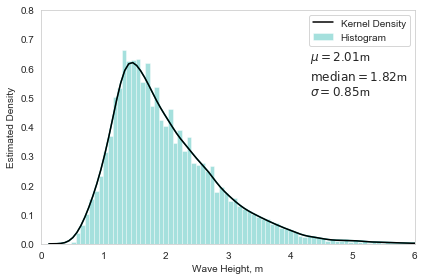

In [132]:
# Focus on wave height column
height = wave_df.Hmax.values

# First draw a histogram
ax = sns.distplot( height, bins=100, color = "lightseagreen", label="Histogram" )

# Add a kernel density estimate
sns.kdeplot( height, color="black", label="Kernel Density")

# Find mean, median and standard deviation
mu = np.mean(height)
med = np.median(height)
sd = np.sqrt(var)

textstr = '\n'.join((
    r'$\mu=%.2f$m' % (mu, ),
    r'$\mathrm{median}=%.2f$m' % (med, ),
    r'$\sigma=%.2f$m' % (sd, )))

# Add labels
plt.xlabel('Wave Height, m')
plt.ylabel('Estimated Density')

# Add tick marks abd set the limits of the axes
plt.xticks((0,1,2,3,4,5,6))
plt.xlim([0,6])
plt.ylim([0,0.8])
plt.tight_layout()

# draw a text box
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place box in upper left in axes coords
ax.text(0.72, 0.83, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

# Save a PDF version, then display the result here too
plt.savefig('Figures/2019waves_distplot.pdf')
plt.show()

The mode is 1.4710064878826832 
The variance is 0.7225903838995871 
The standard deviation is 0.8500531653370789 
The skewness is 1.2324272246205539 
The kurtosis is 2.2644746372452316


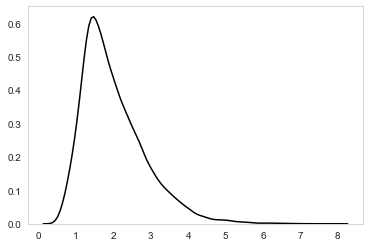

In [134]:
# Use a KDE to estimate the mode
mykde = sns.kdeplot(height, color='k')
xm, ym = mykde.get_lines()[0].get_data()
mo = xm[np.argmax(ym)]

#Compute variance, sd, skewness and kurtosis
var = np.var(height, ddof=1)
sd = np.sqrt(var)
skew = st.moment(height,3)/(sd**3)
kurt = (st.moment(height,4)/(sd**4))-3

print("The mode is", mo,
      "\nThe variance is", var, 
      "\nThe standard deviation is", sd,
      "\nThe skewness is", skew,
      "\nThe kurtosis is", kurt)

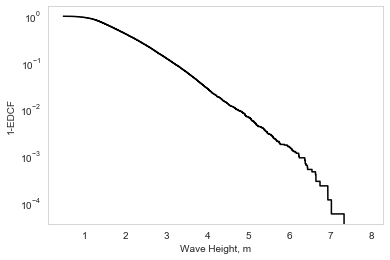

In [139]:
#Import the ECDF with
from statsmodels.distributions.empirical_distribution import ECDF

# Plot the ECDF
ecdf= ECDF(height)

# Plot the survival function
plt.step(ecdf.x, 1-ecdf.y, color='k')
plt.yscale('log')
plt.xlabel("Wave Height, m")
plt.ylabel("1-EDCF")

plt.savefig('Figures/2019waves_survplot.pdf')

# Multivariate Analysis

Covariance Matrix:
 [[ 0.72259038 -0.04622344  0.56456678]
 [-0.04622344  6.46546591 -1.21095154]
 [ 0.56456678 -1.21095154  4.96163335]]


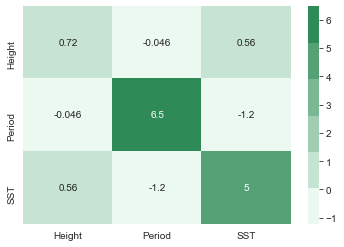

In [131]:
# Focus on wave height, period and sea temp
X = wave_df[["Hmax", "Tp", "SST"]]

# Find covariance matrix
S = np.cov(X, rowvar=False)

# Plot a heat map 
sns.heatmap(S, xticklabels=["Height", "Period", "SST"], yticklabels=["Height", "Period", "SST"], 
            annot=True, cmap=sns.light_palette("seagreen"))

plt.savefig('Figures/2019waves_covplot.pdf')


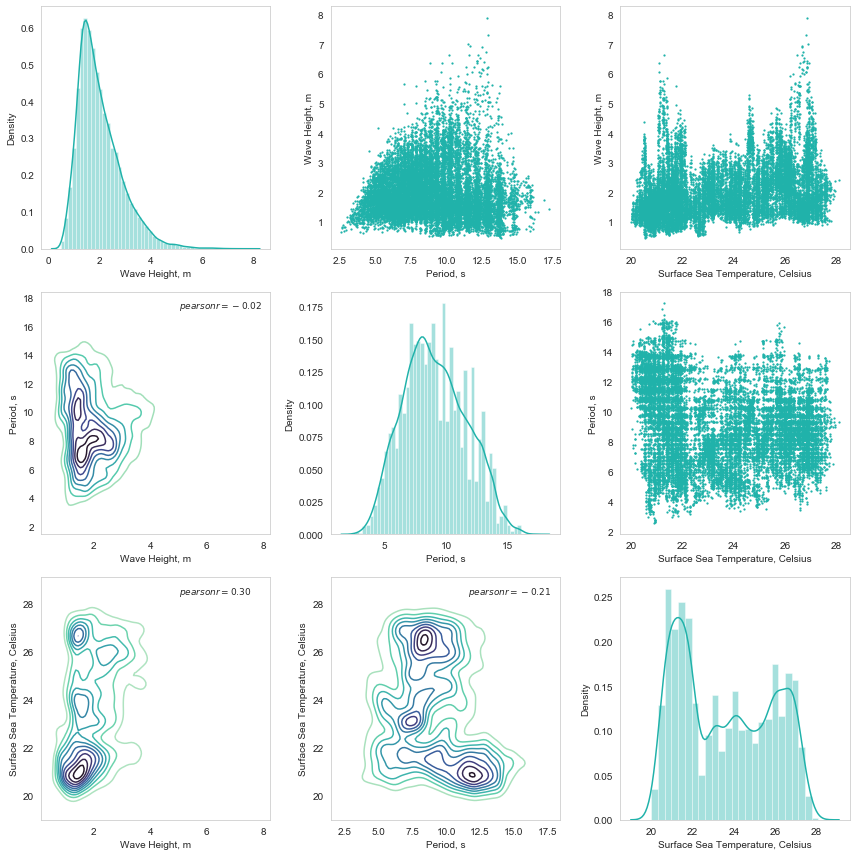

In [120]:
names=["Wave Height, m", "Period, s", "Surface Sea Temperature, Celsius"]
X = wave_df[["Hmax", "Tp", "SST"]]

# Form plot matrix
plt.figure(figsize=(12,12))
for i in range(0,3):
    for j in range(0,3):
        plt.subplot(3,3,1+i+(3*j))
        if i==j:
            # Draw histograms and KDEs on the diagonal using
            # whichever version of Seaborn command is appropriate
            seabornVersionStr = sns.__version__
            versionStrParts = seabornVersionStr.split('.')
            if( int(versionStrParts[1]) < 11 ):
                # Use the older, now-deprectaed form
                sns.distplot(X.iloc[:,i],color="lightseagreen")
            else:
                # Use the more recet form
                sns.kdeplot( X.iloc[:,i], color="black", label="Kernel Density")
                sns.histplot( X.iloc[:,i], stat="density", color = "lightseagreen" )
                
            # Add labels
            plt.xlabel(names[i])
            plt.ylabel('Density')
        else:
            if i<j:
                # Plot two-dimensional KDEs below the diagonal
                kd = sns.kdeplot(np.ravel(X.iloc[:,i]), np.ravel(X.iloc[:,j]),cmap="mako_r")      
                
                # Calculate and write into text box the correlation coefficent
                (r, p) = st.pearsonr(X.iloc[:,i],X.iloc[:,j])
                
                textstr = r'$pearsonr=%.2f$' % (r, )

                props = dict(boxstyle='round', facecolor='white')

                # place a text box in upper left in axes coords
                kd.text(0.60, 0.97, textstr, fontsize=9,
                        verticalalignment='top', transform=kd.transAxes, bbox=props)
            else:
                # Put scatterplots above the diagonal
                sns.scatterplot(X.iloc[:,i],X.iloc[:,j],facecolor="lightseagreen",marker=".", linewidth=0, s=20)
            
            
            # Add labels
            plt.ylabel(names[j])
            plt.xlabel(names[i])
            
plt.tight_layout()
plt.savefig('Figures/2019waves3.pdf',format='pdf')